In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

%cd /content/drive/MyDrive/Sun/ML Shock/Final project/

/content/drive/MyDrive/Sun/ML Shock/Final project


# Convolutional Neural Networks


In [3]:
import sys
# sys.path.insert(0,"C:/Users/Amy/Desktop/Green_Git/eegClassification/utils")
sys.path.insert(0,"/content/drive/MyDrive/Sun/ML Shock/Final project/")

In [4]:
# Import libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from CustomDataset import CustomDataset
from torch.utils.data import DataLoader

from scipy.special import kl_div

import os

In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


---
## Load the Data

In [6]:
# Load (train or test) data from csv file
# path = "C:/Users/Amy/Desktop/Green_Git/eegClassification/sample_data/"
# path_df = "C:/Users/Amy/Desktop/Green_Git/eegClassification/files/"
# scaler_path = "C:/Users/Amy/Desktop/Green_Git/eegClassification/models/scalers/"

path = "./data/"
path_df = "./"
scaler_path = "./data/"
path_model = "./model_v1.pt"


In [7]:
# Type of input data
data_type = "spec" # "eeg_raw" #"eeg_spec"  #
# Type of mscale
scaler_type = "min_max" #"standard" #
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16

In [8]:
if data_type == "spec":
    input_shape = (4,299,100)
elif data_type == "eeg_spec":
    input_shape = (20,129,43)
elif data_type == "eeg_raw":
    input_shape = (20,9800)

In [9]:
# load scaler from pickle
import pickle
scaler_name = data_type + "_" + scaler_type + "_scaler" + ".pkl"
scaler = pickle.load(open(scaler_path + scaler_name, 'rb'))

In [10]:
# Data transform to convert data to a tensor and apply scaler
# no data augmentation
transform = (lambda x: scaler.transform(x.reshape(1,-1)).reshape(*input_shape),)

In [11]:
def load_data(path, path_df, data_type, text):

    train=True
    df = pd.read_csv(path_df + f"{text}_processed.csv")



    data_dir = (
        f"train_eegs/"
        if "eeg" in data_type
        else f"train_spectrograms/"
    )
    data_dir = path + data_dir

    ###
    # files = os.listdir(data_dir)
    # df = df[
    #     df["eeg_id" if "eeg" in data_type else "spectrogram_id"].isin(
    #         [int(f.split(".")[0]) for f in files]
    #     )
    # ]
    ###

    votes_cols = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]
    label_cols = (
        ["eeg_id", "label_id", "eeg_label_offset_seconds"]
        if "eeg" in data_type
        else ["spectrogram_id", "label_id", "spectrogram_label_offset_seconds"]
    )
    offset = (
        ["eeg_label_offset_seconds"]
        if "eeg" in data_type
        else ["spectrogram_label_offset_seconds"]
    )

    # if info_cols not in df add it and set to zero
    for col in offset:
        if col not in df.columns:
            df[col] = 0
    # if df does not contain "label_id" add a unique label_id
    if "label_id" not in df.columns:
        df["label_id"] = range(len(df))

    info = {}
    df_gr = df.groupby(label_cols)
    for name, group in df_gr:
        # first row of group
        info[name] = {"votes": group[votes_cols].values[0] if train else None}

    return data_dir, data_type, info


In [12]:
data_dir, data_type, info = load_data(path, path_df, data_type, "train")
data_dir, data_type, len(info)

('./data/train_spectrograms/', 'spec', 65509)

In [13]:
train_data = CustomDataset(data_dir, data_type, info, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)


In [14]:
data_dir, data_type, info_test = load_data(path, path_df, data_type, "test")
data_dir, data_type, len(info_test)

('./data/train_spectrograms/', 'spec', 19514)

In [15]:
test_data = CustomDataset(data_dir, data_type, info_test, transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [16]:
data_dir, data_type, info_val  = load_data(path, path_df, data_type, "val")
data_dir, data_type, len(info_val)

('./data/train_spectrograms/', 'spec', 21777)

In [17]:
valid_data = CustomDataset(data_dir, data_type, info_val, transform=transform)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [18]:
# specify the image classes
classes = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]
N_classes = len(classes)
classes

['seizure_vote',
 'lpd_vote',
 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote']

In [19]:
%%time
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels, votes = next(dataiter)
images = images.numpy() # convert images to numpy for display
images.shape # (number of examples: 20, number of channels: 3, pixel sizes: 32x32)

(16, 4, 299, 100)

In [20]:
labels, votes, images.reshape(batch_size, -1).shape

(tensor([4, 4, 5, 3, 4, 3, 0, 3, 0, 4, 4, 0, 0, 3, 4, 0]),
 tensor([[ 0,  0,  0,  0,  3,  0],
         [ 0,  0,  0,  0,  3,  0],
         [ 0,  0,  0,  2,  2,  7],
         [ 0,  0,  0,  3,  0,  0],
         [ 0,  0,  0,  0, 13,  2],
         [ 0,  0,  0,  3,  0,  0],
         [14,  0,  1,  0,  0,  0],
         [ 0,  0,  0,  3,  0,  0],
         [ 4,  0,  0,  0,  0,  1],
         [ 0,  0,  0,  0,  3,  0],
         [ 0,  0,  0,  1,  9,  2],
         [ 3,  0,  0,  0,  0,  0],
         [ 3,  0,  0,  0,  0,  0],
         [ 0,  2,  0, 13,  0,  0],
         [ 0,  0,  0,  2,  6,  4],
         [ 3,  0,  0,  0,  0,  0]]),
 (16, 119600))

In [21]:
np.min(images.reshape(batch_size, -1)), np.max(images.reshape(batch_size, -1))

(nan, nan)

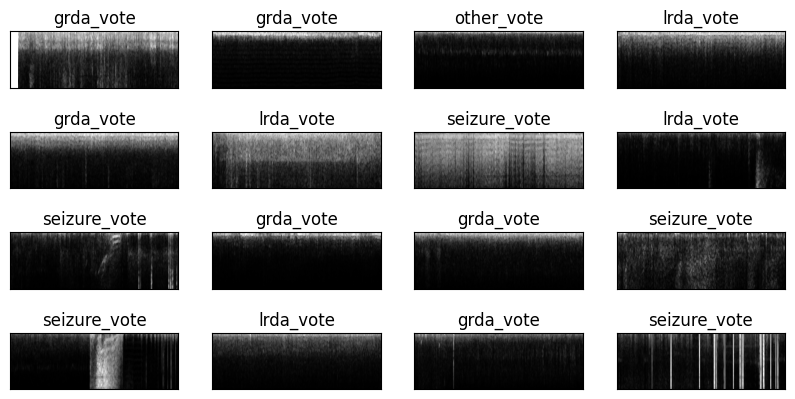

In [22]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 5))
# display 20 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
    # show black and white images
    ax.imshow(images[idx][0,:,:].T, cmap='gray')
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

In [23]:
# idx = 0
# rgb_img = np.squeeze(images[idx])
# channels = ['channel 1', 'channel 2', 'channel 3', 'channel 4']

# fig = plt.figure(figsize = (36, 36))
# for idx in np.arange(rgb_img.shape[0]):
#     ax = fig.add_subplot(4,1, idx + 1)
#     img = rgb_img[idx].T
#     ax.imshow(img, cmap='gray')
#     ax.set_title(channels[idx])
#     width, height = img.shape
#     thresh = img.max()/2.5
#     for x in range(width):
#         for y in range(height):
#             val = round(img[x][y],2) if img[x][y] !=0 else 0
#             ax.annotate(str(val), xy=(y,x),
#                     horizontalalignment='center',
#                     verticalalignment='center', size=8,
#                     color='white' if img[x][y]<thresh else 'black')


## Define the Network Architecture


In [24]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(input_shape[0], 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.N_out = batch_size*32*(input_shape[1]//2//2//2)*(input_shape[2]//2//2//2)
        self.fc1 = nn.Linear(self.N_out, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, N_classes)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, self.N_out)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.log_softmax(self.fc2(x), dim=1)

        return x

In [25]:

# m = nn.MaxPool2d(2, 2)
# c1 = nn.Conv2d(input_shape[0], 16, 3, padding=1)
# c2 = nn.Conv2d(16, 32, 3, padding=1)
# c3 = nn.Conv2d(32, 64, 3, padding=1)
# input = torch.randn(16,4, 299, 100)
# output = m(c3(m(c2(m(c1(input))))))

In [26]:
# output.shape,

In [27]:
# 454656, batch_size*64*(input_shape[1]//2//2//2)*(input_shape[2]//2//2//2)

In [28]:
# create a complete CNN
model = Net()
model

Net(
  (conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=227328, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=6, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [29]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

### Specify [Loss Function](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html#torch.nn.KLDivLoss) and [Optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)


In [30]:
criterion = nn.KLDivLoss(reduction="batchmean")
optimizer = optim.Adam(model.parameters(), lr=0.003)

---
## Train the Network


In [ ]:
# number of epochs to train the model
n_epochs = 1

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, label, votes in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
           data, label, votes = data.cuda(), label.cuda(), votes.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # loss
        loss = criterion(output.float(), F.softmax(votes.float(), dim=1))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for data, label, votes in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, label, votes = data.cuda(), label.cuda(), votes.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output.float(), F.softmax(votes.float(), dim=1))
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), path_model)
        valid_loss_min = valid_loss

###  Load the Model with the Lowest Validation Loss

In [ ]:
model.load_state_dict(torch.load(path_model))

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(N_classes))
class_total = list(0. for i in range(N_classes))

model.eval()
# iterate over test data
for data, target, votes in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target, votes = data.cuda(), target.cuda(), votes.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, F.softmax(votes, dim=1))
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))